# 4-6. 로지스틱 회귀 뉴런으로 단일층 신경망을 만듭니다.

### 신경망 구조  
<img src="imgs/4-6.png" alt="genearl_layer" width="400"/>

In [1]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

In [2]:
x = cancer.data
y = cancer.target

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [4]:
class SingleLayer:
    def __init__(self, learning_rate = 0.1):
        self.w = None
        self.b = None
        self.lr = learning_rate
        self.losses = []
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z
    
    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def activation(self, z): # z is an numpy array
        a = 1 / (1 + np.exp(-z))
        return a
    
    def fit(self, x, y, epochs=100, shuffle=True):
        self.w = np.ones(x.shape[1]) # x.shape[1] : feature 개수
        self.b = 0
        for _ in range(epochs):
            loss = 0
            if shuffle:
                indexes = np.random.permutation(np.arange(len(x))) # 샘플 순서 섞기
                for i in indexes:
                    z = self.forpass(x[i])
                    a = self.activation(z)
                    err = -(y[i] - a)
                    w_grad, b_grad = self.backprop(x[i], err)
                    self.w -= w_grad
                    self.b -= b_grad
                    a = np.clip(a, 1e-10, 1-1e-10)
                    loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
                    
            else:
                for i in range(len(x)):
                    z = self.forpass(x[i])
                    a = self.activation(z)
                    err = -(y[i] - a)
                    w_grad, b_grad = self.backprop(x[i], err)
                    self.w -= w_grad
                    self.b -= b_grad
                    a = np.clip(a, 1e-10, 1-1e-10)
                    loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
                     
            self.losses.append(loss/len(y))
                     
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        # a = self.activation(np.array(z))
        # return a > 0.5        
        return np.array(z) > 0
    
    def forpass_batch(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def backprop_batch(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m
        b_grad = np.sum(err) / m
        return w_grad, b_grad
    
    def fit_batch(self, x, y, epochs=100):
        y = y.reshape(-1, 1)
        m = len(x)
        self.w = np.ones((x.shape[1], 1))
        self.b = 0

        for _ in range(epochs):
            z = self.forpass_batch(x)
            a = self.activation(z)
            err = -(y - a)
            w_grad, b_grad = self.backprop_batch(x, err)
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append(loss / m)
    
    def predict_batch(self, x):
        z = self.forpass_batch(x)
        return np.array(z) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

- self.losses: epoch 마다 달라지는 loss 값을 저장
- np.clip: a 가 0에 매우 가까워지면, log(a)가 음의 무한대로, a가 1에 매우 가까워지면, log(1-a)가 음의 무한대로 가게 되어 loss 계산이 어려워짐.  
a의 값을 $10^{-10} \sim 1 - 10^{-10}$ 로 제한.
- 각 샘플에 대한 err 와 grad를 계산하여 적용 -> 확률적 경사하강법
- 훈련 세트 샘플 순서 섞기: 섞지 않으면 최적값 탐색 과정에서 특정 범위에만 머무르고 벗어나지 못할 수 있음. 샘플 순서를 섞어줌으로써 다양한 방향으로 최적값 탐색을 시도할 수 있게 해줌.
- predict: activation 값이 0.5 초과이면 z가 0 초과 이므로, 단순화

### 확률적 경사하강법

#### 샘플 순서 섞지 않음

In [5]:
layer = SingleLayer()
layer.fit(x_train, y_train, shuffle=False)

C:\Users\skkuj\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


In [6]:
layer.score(x_test, y_test)

0.8245614035087719

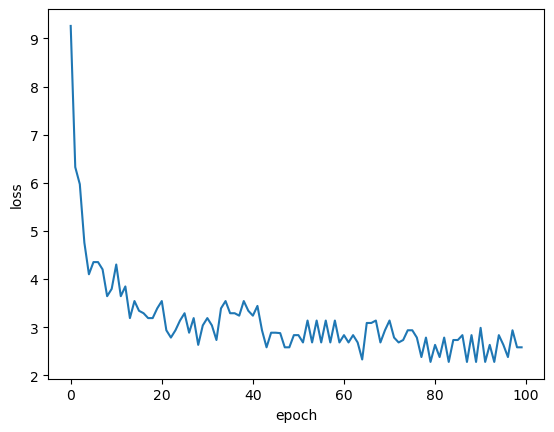

In [7]:
plt.plot(layer.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 샘플 순서 섞음

In [8]:
layer = SingleLayer()
layer.fit(x_train, y_train)

C:\Users\skkuj\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


In [9]:
layer.score(x_test, y_test)

0.9385964912280702

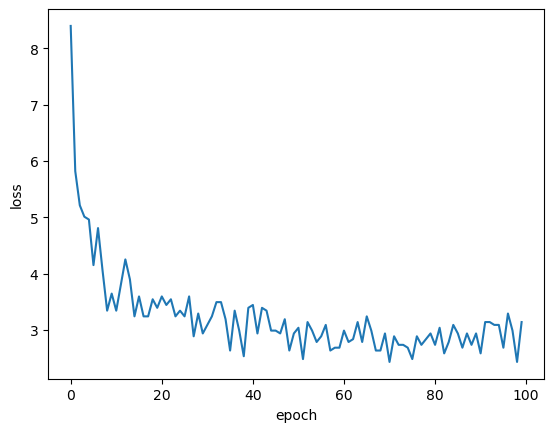

In [10]:
plt.plot(layer.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 배치 경사 하강법

In [11]:
layer = SingleLayer(0.0003)
layer.fit_batch(x_train, y_train)

C:\Users\skkuj\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


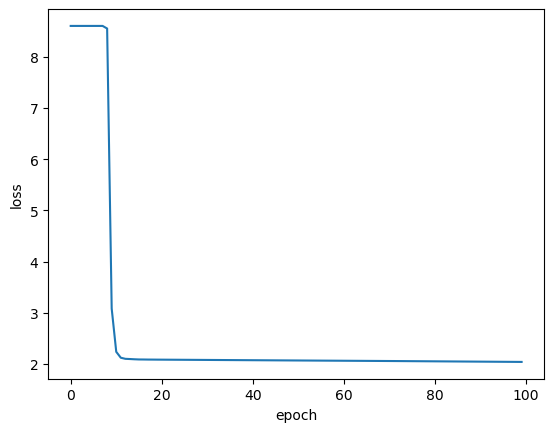

In [12]:
plt.plot(layer.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 4-7. 사이킷런으로 로지스틱 회귀를 수행합니다

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd = SGDClassifier(loss='log', max_iter=100, tol=1e-3, random_state=42)

In [15]:
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.8333333333333334

In [16]:
sgd.predict(x_test[0:10])

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [17]:
y_test[0:10]

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0])